In [15]:
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
execfile('Imports.py')
import Modules.Funcs as funcs
from Modules.Classes import Simulation
from Modules.Classes import CopyTweak
from Modules.Classes import CopyTweakRep
from Modules.Classes import Packer
from Modules.Classes import PackerRep
from Modules.Classes import ConjugateJK13
from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Specify default dataname
dbname = 'experiments-5con.db'#raw data
dataname_def = '5con'#bestparms also comes from here

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = True
saveplots = True
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000
if fitlast and showlast:
    savedir = 'private/individual_modelcomp_{}/fitlast'.format(dataname_def)
elif showlast:
    savedir = 'private/individual_modelcomp_{}/showonlylast/'.format(dataname_def)
elif fitlast:
    savedir = 'private/individual_modelcomp_{}/fitlast'.format(dataname_def)
else:
    savedir = 'private/individual_modelcomp_{}/showall'.format(dataname_def)
# savefilename='modelvsppt{}_t.pdf'.format(corrtype)
# modeleaseDB = "pickles/modelease_corr{}.p".format(corrtype)

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10


participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

# get best params pickle
#bestparmdb = "pickles/chtc_gs_best_params_all_data_e1_e2.p"
#bestparmdb = "pickles/chtc_gs_best_params_corrs.p"
with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild it into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
#modelPlotOrder = np.array([[CopyTweak,CopyTweakRep],[Packer,RepresentJK13]])

#Prepare matched database    
matchdb='../cat-assign/data_utilities/cmp_midbot.db'
        
unique_trials = 'all'
trials.task = task




In [16]:
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()


In [55]:
a = np.array([[1,2],[1,3],[5,4],[2,23]])
ax = 1
b = a[:,ax].copy()
c = b+np.array([-1,2,-4,5])
print(b)
print(c)
d = np.min([b,c],axis=0)
a[:,1] = d
a

[ 2  3  4 23]
[ 1  5  0 28]


array([[ 1,  1],
       [ 1,  3],
       [ 5,  0],
       [ 2, 23]])

In [32]:
#Go through each participant and get their fits for each model
ll = []
ll_trials = []
tally = np.zeros(2)
wins = []
for ppt in trials.participants:
    ppt = int(ppt)
    print('Ppt: ' + str(ppt))
    llrow = []
    if fitlast:
        extract_trials = 3
    else:
        extract_trials = 'all'
    conditionStr = participants.condition[participants.participant==ppt].values
    pptconstr = conditionStr[0][0:2]
    if "Corner" in conditionStr[0]:
        pptconstr += conditionStr[0][-1] #Add info on whether square or circle
    
    trialppt = Simulation.extractPptData(trials, ppt=ppt, unique_trials=extract_trials)
    #Get list of lls and winning model
    for model in modelList:
        params = best_params[model.model]
        ppt_trial_ll = trialppt.loglike(params=params,model=model,parmxform=False)
        llrow += [ppt_trial_ll]
    bestmodel = llrow.index(np.min(llrow))
    bestmodelstr = modelList[bestmodel].modelshort
    ll += [[ppt]+llrow]
    tally[bestmodel] += 1
    wins += [bestmodel]
    #Prepare stuff fot plotting
    if doplots:
        
        #Sort trial obj by trial number - really only applicable if onlylast is false                                                                                                                   
        trialOrder = []
        maxbeta = 0
        for t,trialobj in enumerate(trialppt.Set):
            nbeta = len(trialobj['categories'][1])
            trialppt.Set[t]['trial'] = nbeta
            trialOrder += [nbeta]
            maxbeta = max(nbeta,maxbeta)
        trialOrder = np.argsort(trialOrder)
        #Add dummy last trial to plot gradients for hypothetical fifth beta
        newcatB = np.append(trialppt.Set[trialOrder[maxbeta]]['categories'][1],trialppt.Set[trialOrder[maxbeta]]['response'])
        newcatAll = [trialppt.Set[trialOrder[maxbeta]]['categories'][0],newcatB]
        trialppt.add(response=0,categories=newcatAll, participant = ppt)
        trialOrder = np.append(trialOrder,maxbeta+1)
        
        if showlast:
            ntrials = 1
            plottrials = [len(trialppt.Set)-1] #plot only last trial
        else:
            ntrials = len(trialppt.Set)
            plottrials = range(ntrials)
        f,ax = plt.subplots(ntrials,len(modelList),figsize = (8, 2*ntrials+2.5))
        for trial in plottrials:
            categories = [trialppt.stimuli[i,:] for i in trialppt.Set[trialOrder[trial]]['categories'] if len(i)>0]
            A = categories[0]
            resp = trialppt.stimuli[trialppt.Set[trialOrder[trial]]['response'],:]
            if len(categories)>1:
                #include the response                                                                                                                  
                B = np.append(categories[1],resp,axis=0)
                if showlast:
                    #Include response in generatin of ps                
                    categories[1] = B
            else:
                #categories += [resp]
                B = resp            
            ps = []
            ll_trial = []
            for m,model in enumerate(modelList):
                if m==bestmodel:
                    winstr = '*'
                else:
                    winstr = ''
                if ntrials>1:
                    ax[0,m].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                else:                    
                    ax[m].set_title('{}{}{}, ll={:.2f}'.format(winstr,model.modelshort,winstr,llrow[m]))
                params = best_params[model.model]
                #Plot heatmap for each model
                ps += [model(categories,params,trialppt.stimrange).get_generation_ps(trialppt.stimuli,1,'generate')]
                #Get lls for each trial step
                ll_trial += [trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)]

            #Plot the individual plots
            plotct = 0
            plotVals = []
            psMax = 0
            psMin = 1
            #Get range                                                                                                                                     
            for ps_el in ps:
                psMax = max(psMax,ps_el.max())
                psMin = min(psMin,ps_el.min())

            #Normalise all values                                                                                                                          
            psRange = psMax-psMin
            for i,ps_el in enumerate(ps): #each ps element correspond to a model
                plotct += 1
                gps = funcs.gradientroll(ps_el,'roll')[:,:,0]
                ps_ElRange = gps.max()-gps.min();
                plotVals += [(gps-gps.min())/ps_ElRange]                                                                             
                betacol = ['green' for bi in range(len(B))]
#                 if task is 'generate':
#                     betacol[len(B)-1] = 'orange'
                if ntrials>1:
                    betacol[len(B)-1] = 'orange'
                    if trial == ntrials-1:
                        betacol[len(B)-1] = [0,0,0,0]
                    im = funcs.plotgradient(ax[trial,i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
                    ax[trial,i].set_ylabel('Trial {}'.format(trial))
                    if trial<ntrials-1:
                        ax[trial,i].set_xlabel('ll_trial = {:.2f}'.format(ll_trial[i][trial]),fontsize=10)
                    #else:
                        
                else:
                    im = funcs.plotgradient(ax[i], plotVals[i], A, B, clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
#                     ax[i].set_ylabel('Trial {}'.format(trial))
        #Save fig
        if saveplots:
            savedirext = '{}/{}'.format(savedir,bestmodelstr)
            if os.path.isdir(savedirext):
                plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
            else:
                os.mkdir(savedirext)
                plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
        plt.close()
        ll_trials += [np.array(ll_trial).T]



    


Ppt: 0
Ppt: 1
Ppt: 2
Ppt: 3
Ppt: 4
Ppt: 5
Ppt: 6
Ppt: 7
Ppt: 8
Ppt: 9
Ppt: 10
Ppt: 11
Ppt: 12
Ppt: 13
Ppt: 14
Ppt: 15
Ppt: 16
Ppt: 17
Ppt: 18
Ppt: 19
Ppt: 20
Ppt: 21
Ppt: 22
Ppt: 23
Ppt: 24
Ppt: 25
Ppt: 26
Ppt: 27
Ppt: 28
Ppt: 29
Ppt: 30
Ppt: 31
Ppt: 32
Ppt: 33
Ppt: 34
Ppt: 35
Ppt: 36
Ppt: 37
Ppt: 38
Ppt: 39
Ppt: 40
Ppt: 41
Ppt: 42
Ppt: 43
Ppt: 44
Ppt: 45
Ppt: 46
Ppt: 47
Ppt: 48
Ppt: 49
Ppt: 50
Ppt: 51
Ppt: 52
Ppt: 53
Ppt: 54
Ppt: 55
Ppt: 56
Ppt: 57
Ppt: 58
Ppt: 59
Ppt: 60
Ppt: 61
Ppt: 62
Ppt: 63
Ppt: 64
Ppt: 65
Ppt: 66
Ppt: 67
Ppt: 68
Ppt: 69
Ppt: 70
Ppt: 71
Ppt: 72
Ppt: 73
Ppt: 74
Ppt: 75
Ppt: 76
Ppt: 77
Ppt: 78
Ppt: 79
Ppt: 80
Ppt: 81
Ppt: 82
Ppt: 83
Ppt: 84
Ppt: 85
Ppt: 86
Ppt: 87
Ppt: 88
Ppt: 89
Ppt: 90
Ppt: 91
Ppt: 92
Ppt: 93
Ppt: 94
Ppt: 95
Ppt: 96
Ppt: 97
Ppt: 98
Ppt: 99
Ppt: 100
Ppt: 101
Ppt: 102
Ppt: 103
Ppt: 104
Ppt: 105
Ppt: 106
Ppt: 107
Ppt: 108
Ppt: 109
Ppt: 110
Ppt: 111
Ppt: 112
Ppt: 113
Ppt: 114
Ppt: 115
Ppt: 116
Ppt: 117
Ppt: 118
Ppt: 119
Ppt: 120
Ppt: 121
Ppt: 122
Ppt

In [ ]:
#Checkfail comes from the ind_dummy notebook where I look for ppts whose winning order doesn't match the majority of wins across all permutations 
#That is to say, the order of the generated betas seem to matter most for these guys
checkfail = np.asarray([11.0, 14.0, 15.0, 56.0, 62.0, 66.0, 70.0, 98.0, 132.0, 133.0, 141.0, 152.0, 160.0, 163.0, 170.0, 171.0, 178.0, 186.0, 187.0, 201.0, 203.0, 210.0, 213.0, 215.0, 216.0, 221.0, 225.0, 226.0, 232.0, 239.0, 267.0, 273.0, 275.0, 300.0],dtype=int)
ll_array = np.array(ll)
ll_checkfail = ll_array[checkfail,:]
ll_checkfail

In [131]:
np.mean(np.array(ll_trials),axis=0)

array([[  3.7626797 ,   3.45957302],
       [  3.84470953,   3.69437229],
       [  3.6846681 ,   3.63070122],
       [  3.56498935,   3.60137974],
       [191.01472097, 190.32768235]])

In [130]:
np.diff(np.mean(np.array(ll_trials),axis=0),axis=1) #positive = packer wins

array([[-0.30310668],
       [-0.15033724],
       [-0.05396688],
       [ 0.03639039],
       [-0.68703861]])

In [122]:
#Calculate cumulative lls at each trial, excluding last trial (since it's a dummy)
ll_trials_cs = [np.cumsum(ppt_trial[:4,:],axis=0) for ppt_trial in ll_trials]
#Get wins at each trial
ll_trials_mins = [np.argmin(ppt_trial[:4,:],axis=1) for ppt_trial in ll_trials_cs]
ll_trials_means = np.mean(np.array(ll_trials),axis=0)
repwins = np.sum(np.array(ll_trials_mins),axis=0)
packerwins = len(ll_trials) - repwins
print('Packer wins, mean lls across trials:')
print(packerwins)
print
print('Representativeness wins, mean lls across trials:')
print(repwins)

Packer wins, mean lls across trials:
[111 109 117 123]

Representativeness wins, mean lls across trials:
[194 196 188 182]


In [68]:
#Print a summary
print('Tally of bests:')

for m,model in enumerate(modelList):
    print('%s: %.2f' % (model.modelshort,tally[m]))

Tally of bests:
PACKER: 123.00
Representative: 182.00


In [165]:
trialppt.Set

[{'categories': [array([30, 32, 48, 50]), array([], dtype=int64)],
  'participant': array([246]),
  'response': array([72]),
  'trial': 0},
 {'categories': [array([30, 32, 48, 50]), array([ 0, 72, 80])],
  'participant': array([246]),
  'response': array([8]),
  'trial': 3},
 {'categories': [array([30, 32, 48, 50]), array([72])],
  'participant': array([246]),
  'response': array([80]),
  'trial': 1},
 {'categories': [array([30, 32, 48, 50]), array([72, 80])],
  'participant': array([246]),
  'response': array([0]),
  'trial': 2},
 {'categories': [array([30, 32, 48, 50]), array([ 0,  8, 72, 80])],
  'participant': [246],
  'response': [0]}]

In [102]:
trialppt.Set[len(trialppt.Set)-1]['categories']

[array([14, 16, 32, 34]), array([ 0, 18, 72, 63])]

In [117]:
temp= cp.deepcopy(trialppt)
newcatB = np.append(temp.Set[len(trialppt.Set)-1]['categories'][1],temp.Set[len(trialppt.Set)-1]['response'])
newcatAll = [temp.Set[len(trialppt.Set)-1]['categories'][0],newcatB]
temp.add(response=np.array([0,0]),categories=newcatAll, participant = ppt)

In [145]:
trialppt.loglike(params=params,model=model,parmxform=False,whole_array=False)

721.369969609176

In [146]:
sum(trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True))

721.369969609176

In [147]:
trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)

array([  2.21172107,   3.97968408, 709.19620864,   2.63851549,
         3.34384033])

In [160]:
newcatAll

[array([30, 32, 48, 50]), array([72, 80,  0])]

In [167]:
maxbeta

3

In [166]:
trialOrder

array([0, 2, 3, 1, 2])

In [72]:
lla = np.array(ll)
packerwins = np.bool_(1-np.array(wins))
repwins = np.bool_(wins)
plist = np.abs(lla[packerwins,1]-lla[packerwins,2])
rlist = np.abs(lla[repwins,1]-lla[repwins,2])
print(np.mean(plist),np.min(plist),np.max(plist))
print(np.mean(rlist),np.min(rlist),np.max(rlist))
print(sum(lla[packerwins,1]))
print(sum(lla[repwins,2]))

(1.3097548838595667, 0.002058463678348943, 9.338029144044272)
(1.6887766946888592, 0.006481777226126084, 6.465465012108455)
1822.5093807065457
2371.0523374970867


(array([50., 33., 21.,  8.,  6.,  2.,  0.,  2.,  0.,  1.]),
 array([2.05846368e-03, 9.35655532e-01, 1.86925260e+00, 2.80284967e+00,
        3.73644674e+00, 4.67004380e+00, 5.60364087e+00, 6.53723794e+00,
        7.47083501e+00, 8.40443208e+00, 9.33802914e+00]),
 <a list of 1 Patch objects>)

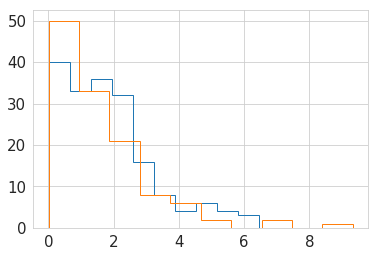

In [71]:
# f = plt.figure()
plt.hist(rlist,histtype='step')
plt.hist(plist,histtype='step')

(array([50., 33., 21.,  8.,  6.,  2.,  0.,  2.,  0.,  1.]),
 array([2.05846368e-03, 9.35655532e-01, 1.86925260e+00, 2.80284967e+00,
        3.73644674e+00, 4.67004380e+00, 5.60364087e+00, 6.53723794e+00,
        7.47083501e+00, 8.40443208e+00, 9.33802914e+00]),
 <a list of 10 Patch objects>)

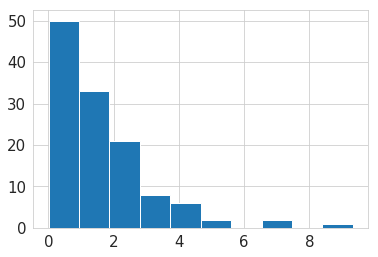

In [62]:
plt.hist(plist)

In [64]:
len(rlist)

182